# Homework 04 - Applied ML

In [86]:
import os
import numpy as np
import pandas as pd
import seaborn as sns  
import matplotlib.pyplot as plt  
from scipy.stats import skew, skewtest, describe
from sklearn import preprocessing
%matplotlib inline

## 1. Predict the skin color of a soccer player

In this first task we train a *Random forest* classifier to be able to predict the skin color of a soccer player. In order to do so, we proceed pre-processing the data as first step then moving toward the choice of the model (interpret as the choice of parameters controlling the possible issues i.e. the *overfitting*). As required, we then switch to the inspection of the `feature_importances_` attribute and the discussion of the obtained results.

### 1.1 Exploratory Data Analysis, Feature Selection and Feature engineering

In [93]:
# Import data 
data = pd.read_csv('CrowdstormingDataJuly1st.csv', sep = ',')

In [94]:
data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


In [95]:
data.columns

Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'rater1', 'rater2',
       'refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp'],
      dtype='object')

##### First clean of data
According to the given information in the [data description](https://github.com/ADAEPFL/Homework/blob/master/04%20-%20Applied%20ML/DATA.md), we get rid off all the dyads that correspond to players whose picture is not available.

In [96]:
data_clean = data[(data.photoID.notnull())]

##### Have a glance at the labels

Thus, we check whether happens that one of the two raters do not assign the label. We see that both of them do their job. 

In [97]:
# How many players the rater 1 don't label?
miss_rater_1 = sum(data_clean.rater1.isnull())
# How many the rater 2?
miss_rater_2 = sum(data_clean.rater2.isnull())

print ('Rater 1 does not label', miss_rater_1, 'players')
print ('Rater 2 does not label', miss_rater_2, 'players')

Rater 1 does not label 0 players
Rater 2 does not label 0 players


We study the distribution of the labels, even to verify disagreements between the two raters. The procedure consist of:
- Grouping by the `playerShort`
- Get the given labels
- Plot their distribution using a *simple* barplot

In [98]:
# Drop dyads weigth and height
data_clean = data_clean.dropna(axis=0, subset=['height', 'weight'])

In [99]:
player_data = data_clean.groupby('playerShort')

Verify that all the players only belong to one club

In [100]:
player_data.agg({'club' : lambda x: len(set(x))})['club'].unique()

array([1])

In [101]:
player_data.agg({'position' : lambda x: len(set(x))})['position'].unique()

array([1])

In [102]:
players = player_data.agg({
        'club' : 'first',
        'leagueCountry' : 'first',
        'birthday' : 'first',
        'height' : 'first',
        'weight' : 'first',
        'position' : 'first',
        'games' : 'sum',
        'victories' : 'sum',
        'ties' : 'sum',
        'defeats' : 'sum',
        'goals' : 'sum',
        'yellowCards': 'sum',
        'yellowReds': 'sum',
        'redCards' : 'sum',
        'rater1' : 'mean',
        'rater2' : 'mean',
        'refNum' : 'count',
        #'refCountry' : 'count',
        'meanIAT' : 'mean',
        'meanExp' : 'mean'
        
    })

In [103]:
label_1 = players['rater1']

In [104]:
label_2 = players['rater2']

In [105]:
def preprocess_labels(label):
    le = preprocessing.LabelEncoder()
    le.fit(label)
    label = le.transform(label) 
    return label

In [106]:
label_1 = pd.Series(preprocess_labels(label_1))
label_2 = pd.Series(preprocess_labels(label_2))

In [107]:
players.drop('rater1', axis = 1, inplace = True)

In [108]:
players.drop('rater2', axis= 1, inplace = True)

### Baseline model

In [109]:
from sklearn.ensemble import RandomForestClassifier

In [110]:
from sklearn.utils import shuffle

In [111]:
from sklearn.multioutput import MultiOutputClassifier

#### Preprocess variable to be used as input for the classifier

In [112]:
players['birthday'] = players['birthday'].apply(lambda x: float(x.split('.')[-1]))

In [113]:
def encode_string_variable(df, attribute):
    
    df[attribute] = df[attribute].fillna('Unknown')
    
    le = preprocessing.LabelEncoder()
    
    le.fit(df[attribute])
    
    df[attribute] = le.transform(df[attribute]) 

In [114]:
# Get the string variables
object_features = [i for i in players.columns if players[i].dtypes == 'object']
numerical_features = [i for i in players.columns if (players[i].dtypes == 'int64' or players[i].dtypes == 'float64') and len(players[i].unique()) > 12]

In [115]:
for feature in object_features:
    encode_string_variable(players, feature)

##### Categorise features

In [116]:
def categorise_numerical_variables(df, attribute, number_bins):
        
    # Get the whiskers values
    B = plt.boxplot(df[attribute])
    plt.close()
    min_max = [item.get_ydata()[1] for item in B['whiskers']]
    
    # Compute the Skew-test
    skew_pvalue = skewtest(df[attribute][df[attribute] >= min_max[0]])[1]
    
    if skew_pvalue >= 0.05:
        print ('Not Skewed')
        #df[attribute] = pd.cut(df[attribute], number_bins, labels = range(number_bins))
        df[attribute] = pd.cut(df[attribute], number_bins, labels = range(number_bins))
        return df[attribute]
    else: 
        print ('Skewed')
        #df[attribute] = pd.qcut(df[attribute], number_bins, labels = range(number_bins))
        df[attribute] = pd.qcut(df[attribute], number_bins, labels = range(number_bins))
    #return df[attribute]
        return df[attribute]

In [117]:
numerical_features

['defeats',
 'meanIAT',
 'yellowCards',
 'height',
 'refNum',
 'weight',
 'birthday',
 'goals',
 'meanExp',
 'victories',
 'games',
 'ties']

In [118]:
players['defeats'].unique()

array([228, 122, 115,  68,  43,  33,   8,   2,  62,  25,  12,  92,  32,
        48,  60,  69,  51, 126,  36,  45,  59,  16,  86,  71,  82, 134,
        87,  85,  10,  65,  49,  97,  13, 130,  70,   9,  46,  52,  50,
        90,  29,  54,   4,  73,  26,  47,  58,  57, 103, 111, 136,  31,
        72, 102,  91,  64, 116,   7, 101,  99,  24,  53,  44,  94,  30,
        20,  74,  15, 150,  88,  61, 117,  39,  78,  89, 153,  79, 128,
       139, 148, 140, 129, 114,  84, 105, 137,  98,  81, 107,  66,   6,
        55, 119, 112, 113,  37,  96,  56, 185,   0,  23,  63,  38,  41,
       123, 144, 125, 154, 121,   5, 108,  67, 132, 100,  83, 184, 104,
        34,  95, 146,  80, 141, 143, 157,  21, 145,  35,  40, 147,   3,
        76,  18, 138,  22,  93, 193,  19,  75, 171, 161, 127, 170, 109,
       167,  17,  42,  27,  28, 163, 120, 106, 194, 196, 131, 162, 149,
        77,  14, 156, 174,  11, 169, 152, 175, 118, 142, 158, 124, 205,
       110, 210, 216,   1, 151, 259, 159, 133, 135, 212, 160, 17

In [123]:
np.histogram(players[numerical_features[0]], bins = 'doane')

array([   0.    ,   16.1875,   32.375 ,   48.5625,   64.75  ,   80.9375,
         97.125 ,  113.3125,  129.5   ,  145.6875,  161.875 ,  178.0625,
        194.25  ,  210.4375,  226.625 ,  242.8125,  259.    ])

In [87]:
describe(players[numerical_features[0]])

DescribeResult(nobs=1564, minmax=(0, 3), mean=0.67135549872122757, variance=0.46262106611817716, skewness=0.6517231446511276, kurtosis=-0.13311858204590576)

{'boxes': [<matplotlib.lines.Line2D at 0x118526c88>],
 'caps': [<matplotlib.lines.Line2D at 0x11851a550>,
 'fliers': [<matplotlib.lines.Line2D at 0x118476cc0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x118476940>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1185263c8>,
  <matplotlib.lines.Line2D at 0x11851a198>]}

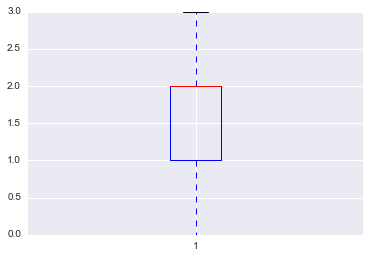

In [89]:
plt.boxplot(players[numerical_features[1]])

In [88]:
for feature in numerical_features:
    print (feature)
    players[feature] = categorise_numerical_variables(players, feature, 4)

defeats
Skewed
meanIAT
Skewed
yellowCards
Skewed
height
Not Skewed


ValueError: Bin edges must be unique: array([ 0.,  0.,  1.,  2.,  3.])

#### Split train and test

In [77]:
from sklearn.model_selection import train_test_split

In [78]:
X_train, X_test, y_train, y_test = train_test_split(players, label_1, test_size=0.33, random_state=42)

In [79]:
y_train_2, y_test_2 = label_2[y_train.index], label_2[y_test.index]

In [80]:
forest = RandomForestClassifier(n_estimators=100, random_state=1)

In [81]:
multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)

In [82]:
multi_label =  np.array([ y_train, y_train_2]).T
multi_label_test = np.array([ y_test, y_test_2]).T

In [83]:
prediction = multi_target_forest.fit(X_train, multi_label).predict(X_test)

In [84]:
classifier_1 = []
classifier_2 = []
for i,j in prediction:
    classifier_1 += [i] 
    classifier_2 += [j]

In [85]:
sum(y_test == classifier_1)/len(y_test)*100

43.520309477756285

In [49]:
prediction[10]

array([0, 1])

In [50]:
classifier_1[10]

0